## Interventions in the LUCAS Graph

In [1]:
import pandas as pd
import dowhy
import numpy as np
from random import random
import networkx as nx 

### Simulating dataset based on probabilities:

In [70]:
""" Stated probabilities """
# If you want to do an intervention in one node add "return new_probability" at the very beginning
# don't delete the original probabilities

def anxiety_p():
    return 0.64277

def pressure_p():
    return 0.32997

def smoking_p(anxiety, pressure):
    return 0
    if anxiety == 0 and pressure == 0:
        return .43118
    if anxiety == 0 and pressure == 1:
        return .74591
    if anxiety == 1 and pressure == 0:
        return .8686
    if anxiety == 1 and pressure == 1:
        return .91576
    
def yellow_p(smoking):
    if smoking == 0:
        return .23119
    if smoking == 1:
        return .95372

def genetics_p():
    return .15953

def cancer_p(genetics, smoking):
    if genetics == 0 and smoking == 0:
        return .23146
    if genetics == 1 and smoking == 0:
        return .86996
    if genetics == 0 and smoking == 1:
        return .83934
    if genetics == 1 and smoking == 1:
        return .99351

def attention_p(genetics):
    if genetics == 0:
        return .28956
    if genetics == 1:
        return .68706
    
def evenday_p():
    return .5

def allergy_p():
    return .32841

def coughing_p(allergy, cancer):
    if allergy == 0 and cancer == 0:
        return .1347
    if allergy == 1 and cancer == 0:
        return .64592
    if allergy == 0 and cancer == 1:
        return .7664
    if allergy == 1 and cancer == 1:
        return .99947
    
def fatigue_p(cancer, coughing):
    if cancer == 0 and coughing == 0:
        return .35212
    if cancer == 1 and coughing == 0:
        return .56514
    if cancer == 0 and coughing == 1:
        return .80016
    if cancer == 1 and coughing == 1:
        return .89589

def accident_p(attention, fatigue):
    if attention == 0 and fatigue == 0:
        return .2274
    if attention == 1 and fatigue == 0:
        return .779
    if attention == 0 and fatigue == 1:
        return .78861
    if attention == 1 and fatigue == 1:
        return .97169

In [71]:
def value_prob(prob):
    return 1 if random() < prob else 0

def node_value(node, previous_values):
    prob = 0
    if node == "Smoking":
        prob = smoking_p(previous_values["Anxiety"], previous_values["Peer_Pressure"])
    if node == "Yellow_Fingers":
        prob = yellow_p(previous_values["Smoking"])
    if node == "Anxiety":
        prob = anxiety_p()
    if node == "Peer_Pressure":
        prob = pressure_p()
    if node == "Genetics":
        prob = genetics_p()
    if node == "Attention_Disorder":
        prob = attention_p(previous_values["Genetics"])
    if node == "Born_an_Even_Day":
        prob = evenday_p()
    if node == "Car_Accident":
        prob = accident_p(previous_values["Attention_Disorder"], previous_values["Fatigue"])
    if node == "Fatigue":
        prob = fatigue_p(previous_values["Lung_cancer"], previous_values["Coughing"])
    if node == "Allergy":
        prob = allergy_p()
    if node == "Coughing":
        prob = coughing_p(previous_values["Allergy"], previous_values["Lung_cancer"])
    if node == "Lung_cancer":
        prob = cancer_p(previous_values["Genetics"], previous_values["Smoking"])

    return value_prob(prob)


In [72]:
#Number of data
N = 10000

data = {
    "Anxiety": [],
    "Peer_Pressure" : [],
    "Smoking" : [],
    "Yellow_Fingers" : [],
    "Genetics" : [],
    "Lung_cancer" : [],
    "Attention_Disorder" : [],
    "Born_an_Even_Day" : [],
    "Allergy" : [],
    "Coughing" : [],
    "Fatigue" : [],
    "Car_Accident" : []
}
order_columns = data.keys()
for _ in range(N):
    row_values = {}
    for node in order_columns:
        value = node_value(node, row_values)
        row_values[node] = value
        data[node].append(value)


In [73]:
generated_df = pd.DataFrame(data)

p = generated_df['Car_Accident'].sum() / generated_df['Car_Accident'].count()
print(f"P(Car_Accident) = {round(p, 5)}")

P(Car_Accident) = 0.6746


#### Creating Causal Graph

['Anxiety' 'Peer_Pressure' 'Smoking' 'Yellow_Fingers' 'Genetics'
 'Lung_cancer' 'Attention_Disorder' 'Born_an_Even_Day' 'Allergy'
 'Coughing' 'Fatigue' 'Car_Accident']


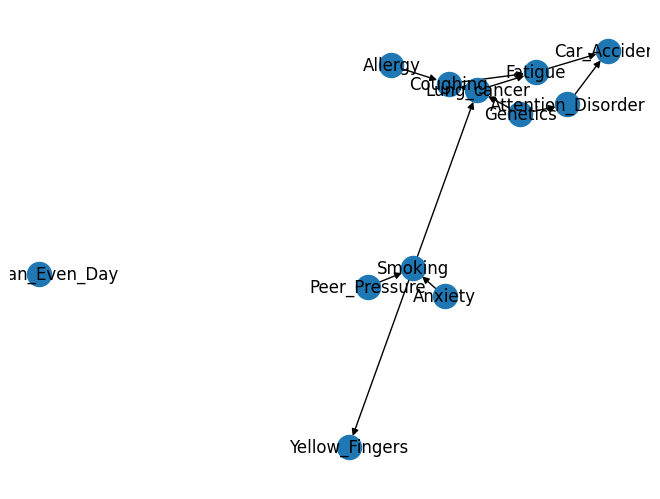

In [105]:
from dowhy import CausalModel

def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

G = nx.DiGraph()

G.add_nodes_from(generated_df.columns.values)

print (generated_df.columns.values)

G.add_edge("Smoking", "Yellow_Fingers")
G.add_edge("Smoking", "Lung_cancer")
G.add_edge("Anxiety", "Smoking")
G.add_edge("Peer_Pressure", "Smoking")
G.add_edge("Genetics", "Lung_cancer")
G.add_edge("Genetics", "Attention_Disorder")
G.add_edge("Smoking", "Lung_cancer")
G.add_edge("Lung_cancer", "Coughing")
G.add_edge("Lung_cancer", "Fatigue")
G.add_edge("Coughing", "Fatigue")
G.add_edge("Allergy", "Coughing")
G.add_edge("Attention_Disorder", "Car_Accident")
G.add_edge("Fatigue", "Car_Accident")


nx.draw(G, with_labels=True, pos=nx.spring_layout(G))
nx.write_gml(G, "intervention_graph.gml")


gml_graph = gml_to_string('lucas_graph.gml')
# With GML string
model=CausalModel(
        data = generated_df,
        treatment='Smoking',
        outcome='Car_Accident',
        graph=gml_graph
        )

In [106]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                      
──────────(E[Car_Accident])
d[Smoking]                 
Estimand assumption 1, Unconfoundedness: If U→{Smoking} and U→Car_Accident then P(Car_Accident|Smoking,,U) = P(Car_Accident|Smoking,)

## Realized estimand
b: Car_Accident~Smoking+Smoking*Attention_Disorder+Smoking*Allergy+Smoking*Genetics
Target units: ate

## Estimate
Mean value: 0.0



c:\Users\aguil\anaconda3\envs\causal_data_science_env\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


P(Car_Accident) = 0.67525
